# Other Parameters

In [1]:
import numpy as np
import gmpy2
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
from collections import defaultdict
from scipy.stats import pearsonr
gmpy2.get_context().precision = 113

# Sets a pastel theme for the plots
sns.set_theme(style="whitegrid", palette="pastel")

### Importing Quickscore

In [2]:
import importlib
from quickscore import fun_quickscoreW2_gmpy2

### Importing Metrics

In [3]:
import metrics
importlib.reload(metrics)
from metrics import compute_metrics

## Number of Diseases `n_disease`

In [4]:
# Random seed for reproducibility
np.random.seed(42)

# Parameters
n_test = 20
expected_number_of_diseases = 4

# Connection Density
sparseness = 0.3

# Sensitivity
sensitivity = 0.4

In [5]:
# Options for n_disease tried
n_diseases = np.arange(5,100,3)
n_options = len(n_diseases)

# Number of trials per one option 
n_trials = 10

# Per trial 
precision_per_trial = np.empty(n_trials)
recall_per_trial = np.empty(n_trials) 
f1_score_per_trial = np.empty(n_trials)
loss_per_trial = np.empty(n_trials)

# Mean across trials

mean_precision = np.empty(n_options)
mean_recall = np.empty(n_options)
mean_f1 = np.empty(n_options)
mean_loss = np.empty(n_options)

for i, n_disease in enumerate(n_diseases):
    print(i)
    # Prevelances
    prev = np.full(n_disease, expected_number_of_diseases/n_disease) 
    
    # Connections matrix
    n_connect = int(n_disease*sparseness)  # each test is connected to a fixed number of diseases, depends on n_disease and sparseness value
    
    connections = np.zeros((n_test, n_disease),dtype=bool)
    for j in range(n_test):
        idx = np.random.choice(n_disease, n_connect, replace=False)
        connections[j,idx] = True
    
    # Fixed sensitivity matrix
    sensorig = np.full((n_test, n_disease), sensitivity ) * connections
    
    for j in range(n_trials):
        flag = 1
        while flag:
            actualdiags = np.where(np.random.rand(n_disease) < prev)[0]  
            ndiags = len(actualdiags)

            testresults = np.any(np.random.rand(n_test, ndiags) < sensorig[:, actualdiags], axis=1)  

            postest = np.where(testresults == 1)[0]
            negtest = np.where(testresults == 0)[0]
            m = len(postest)

            # m and ndiags kept relatively constant with this condition
            if 6<m<8 and ndiags==2:
                flag = 0  # Exit loop if conditions met
    #             print(f"trial: {ndiags:3.0f}, {m:3.0f} OK")
    #         else:
    #             print(m)
    #             print(f"trial: {ndiags:3.0f}, {m:3.0f} try again")

        # Prepare data for Quickscore algorithm
        sens = sensorig[postest, :]                 
        sensneg = sensorig[negtest, :]              
        pfmin = 1 - sens                          
        pfminneg = np.prod(1 - sensneg, axis=0)     

        # Quickscore calculation
        posteriorg, _, _ = fun_quickscoreW2_gmpy2(prev, pfmin, pfminneg)

        actualdiseases = np.zeros_like(prev)
        actualdiseases[actualdiags] = 1

        # Metric Calculation
        metrics = compute_metrics(actualdiseases, posteriorg)
            
        precision_per_trial[j] = metrics["precision"]
        recall_per_trial[j] = metrics["recall"]
        f1_score_per_trial[j] = metrics["f1_score"]
        loss_per_trial[j] = metrics["log_loss"]
    
    # Average Metric 
    mean_precision[i] = np.mean(precision_per_trial)
    mean_recall[i] = np.mean(recall_per_trial)
    mean_f1[i] = np.mean(f1_score_per_trial)
    mean_loss[i] = np.mean(loss_per_trial)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


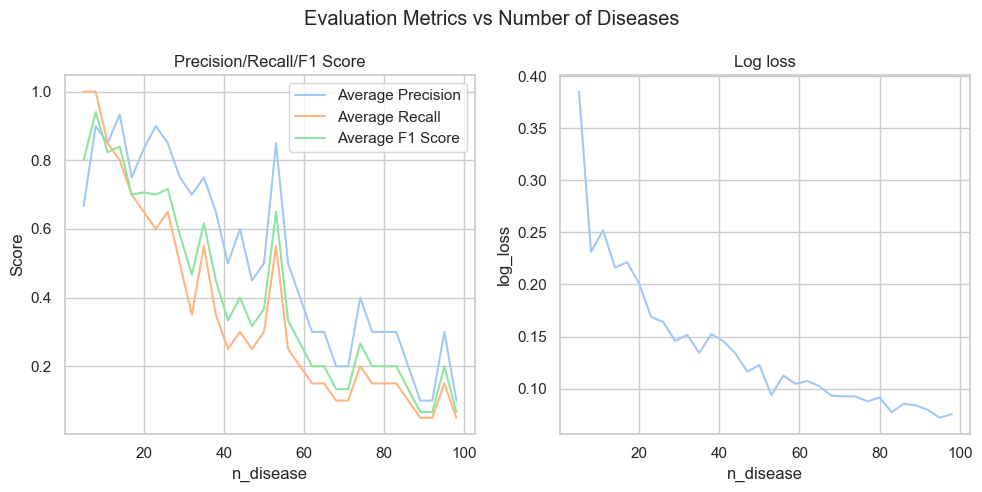

In [6]:
# Plot n_diseases and metrics

fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle("Evaluation Metrics vs Number of Diseases")

ax[0].plot(n_diseases, mean_precision, label="Average Precision")
ax[0].plot(n_diseases, mean_recall, label="Average Recall")
ax[0].plot(n_diseases, mean_f1, label="Average F1 Score")
ax[0].set_xlabel("n_disease")
ax[0].set_ylabel("Score")
ax[0].set_title("Precision/Recall/F1 Score")
ax[0].legend()


ax[1].plot(n_diseases, mean_loss)
ax[1].set_xlabel("n_disease")
ax[1].set_ylabel("log_loss")
ax[1].set_title("Log loss")

plt.tight_layout()
plt.savefig("sp4-A.pdf", dpi=300, bbox_inches='tight')

## Number of Tests `n_test`

In [7]:
# Parameters
n_disease = 15
expected_number_of_diseases = 4

# Connection Density
sparseness = 0.3

# Sensitivity
sensitivity = 0.4

# Prevelances
prev = np.full(n_disease, expected_number_of_diseases/n_disease) 

In [8]:
n_tests = np.arange(5,100,5)
n_options = len(n_tests)

# Number of trials per one option 
n_trials = 5

# Per trial 
precision_per_trial = np.empty(n_trials)
recall_per_trial = np.empty(n_trials) 
f1_score_per_trial = np.empty(n_trials)
loss_per_trial = np.empty(n_trials)


# Mean across trials
mean_precision = np.empty(n_options)
mean_recall = np.empty(n_options)
mean_f1 = np.empty(n_options)
mean_loss = np.empty(n_options)

for i, n_test in enumerate(n_tests):
    print(i)
    
    # Connections matrix
    n_connect = int(n_test*sparseness)  # each disease is connected to a fixed number of tests, depends on n_test
    
    connections = np.zeros((n_test, n_disease),dtype=bool)
    for j in range(n_disease):
        idx = np.random.choice(n_test, n_connect, replace=False)
        connections[idx,j] = True
    
    # Fixed sensitivity matrix
    sensorig = np.full((n_test, n_disease), sensitivity ) * connections
    
    for j in range(n_trials):
        flag = 1
        while flag:
            actualdiags = np.where(np.random.rand(n_disease) < prev)[0]  
            ndiags = len(actualdiags)

            testresults = np.any(np.random.rand(n_test, ndiags) < sensorig[:, actualdiags], axis=1)  

            postest = np.where(testresults == 1)[0]
            negtest = np.where(testresults == 0)[0]
            m = len(postest)

            # m and ndiags kept relatively constant with this condition
            if  0<m<16 and ndiags==2:
                flag = 0  # Exit loop if conditions met
    #             print(f"trial: {ndiags:3.0f}, {m:3.0f} OK")
    #         else:
    #             print(m)
    #             print(f"trial: {ndiags:3.0f}, {m:3.0f} try again")

        # Prepare data for Quickscore algorithm
        sens = sensorig[postest, :]                 
        sensneg = sensorig[negtest, :]              
        pfmin = 1 - sens                          
        pfminneg = np.prod(1 - sensneg, axis=0)     

        # Quickscore calculation
        posteriorg, _, _ = fun_quickscoreW2_gmpy2(prev, pfmin, pfminneg)

        actualdiseases = np.zeros_like(prev)
        actualdiseases[actualdiags] = 1

        # Metric Calculation
        metrics = compute_metrics(actualdiseases, posteriorg)
            
        precision_per_trial[j] = metrics["precision"]
        recall_per_trial[j] = metrics["recall"]
        f1_score_per_trial[j] = metrics["f1_score"]
        loss_per_trial[j] = metrics["log_loss"]
    
    # Average Metric 
    mean_precision[i] = np.mean(precision_per_trial)
    mean_recall[i] = np.mean(recall_per_trial)
    mean_f1[i] = np.mean(f1_score_per_trial)
    mean_loss[i] = np.mean(loss_per_trial)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


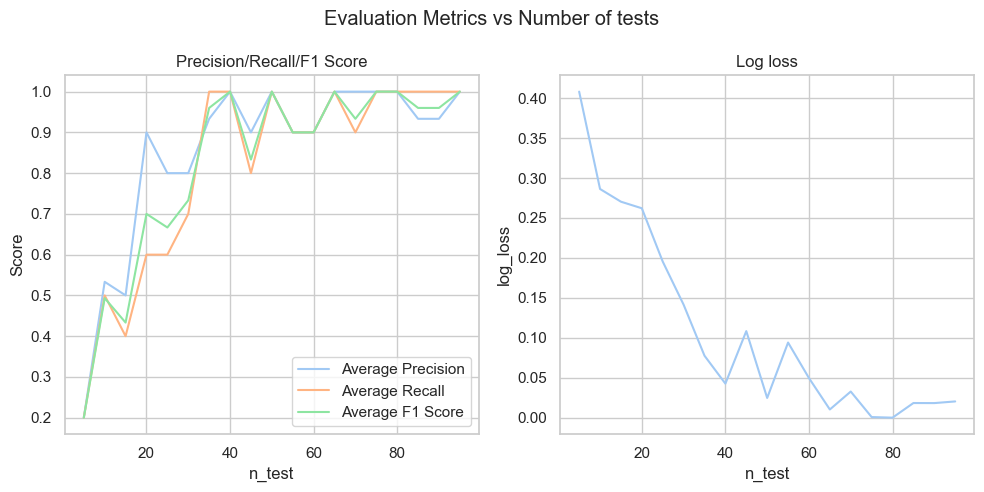

In [9]:
# Plot n_tests x metrics
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle("Evaluation Metrics vs Number of tests")

ax[0].plot(n_tests, mean_precision, label="Average Precision")
ax[0].plot(n_tests, mean_recall, label="Average Recall")
ax[0].plot(n_tests, mean_f1, label="Average F1 Score")
ax[0].set_xlabel("n_test")
ax[0].set_ylabel("Score")
ax[0].set_title("Precision/Recall/F1 Score")
ax[0].legend()


ax[1].plot(n_tests, mean_loss)
ax[1].set_xlabel("n_test")
ax[1].set_ylabel("log_loss")
ax[1].set_title("Log loss")

plt.tight_layout()
plt.savefig("sp4-B.pdf", dpi=300, bbox_inches='tight')

## Number of Expected Diseases

In [5]:
# Parameters
n_test = 30
n_disease = 30

# Connection Density
sparseness = 0.3

# Sensitivity
sensitivity = 0.4

# Random connections matrix
connections = (np.random.rand(n_test, n_disease) < sparseness)*1   
    
# Sensitivity Matrix
sensorig = np.full((n_test, n_disease), sensitivity) * connections

In [6]:
expected_nums = np.arange(1, 14)
n_options = len(expected_nums)

# Number of trials per one option 
n_trials = 10

# Per trial 
precision_per_trial = np.empty(n_trials)
recall_per_trial = np.empty(n_trials) 
f1_score_per_trial = np.empty(n_trials)
loss_per_trial = np.empty(n_trials)


# Mean across trials
mean_precision = np.empty(n_options)
mean_recall = np.empty(n_options)
mean_f1 = np.empty(n_options)
mean_loss = np.empty(n_options)


for i,n in enumerate(expected_nums):
    print(i)
    # Prevalences
    prev = np.full(n_disease, n/n_disease)
    
    for j in range(n_trials):
        flag = 1
        while flag:
            actualdiags = np.where(np.random.rand(n_disease) < prev)[0]  
            ndiags = len(actualdiags)

            testresults = np.any(np.random.rand(n_test, ndiags) < sensorig[:, actualdiags], axis=1)  

            postest = np.where(testresults == 1)[0]
            negtest = np.where(testresults == 0)[0]
            m = len(postest)

            # m and ndiags kept relatively constant with this condition
            if  10<m<15 and ndiags==3:
                flag = 0  # Exit loop if conditions met
    #             print(f"trial: {ndiags:3.0f}, {m:3.0f} OK")
    #         else:
    #             print(m)
    #             print(f"trial: {ndiags:3.0f}, {m:3.0f} try again")

        # Prepare data for Quickscore algorithm
        sens = sensorig[postest, :]                 
        sensneg = sensorig[negtest, :]              
        pfmin = 1 - sens                          
        pfminneg = np.prod(1 - sensneg, axis=0)     

        # Quickscore calculation
        posteriorg, _, _ = fun_quickscoreW2_gmpy2(prev, pfmin, pfminneg)

        actualdiseases = np.zeros_like(prev)
        actualdiseases[actualdiags] = 1

        # Metric Calculation
        metrics = compute_metrics(actualdiseases, posteriorg)
            
        precision_per_trial[j] = metrics["precision"]
        recall_per_trial[j] = metrics["recall"]
        f1_score_per_trial[j] = metrics["f1_score"]
        loss_per_trial[j] = metrics["log_loss"]
    
    # Average Metric 
    mean_precision[i] = np.mean(precision_per_trial)
    mean_recall[i] = np.mean(recall_per_trial)
    mean_f1[i] = np.mean(f1_score_per_trial)
    mean_loss[i] = np.mean(loss_per_trial)
    

0
1
2
3
4
5
6
7
8
9
10
11
12


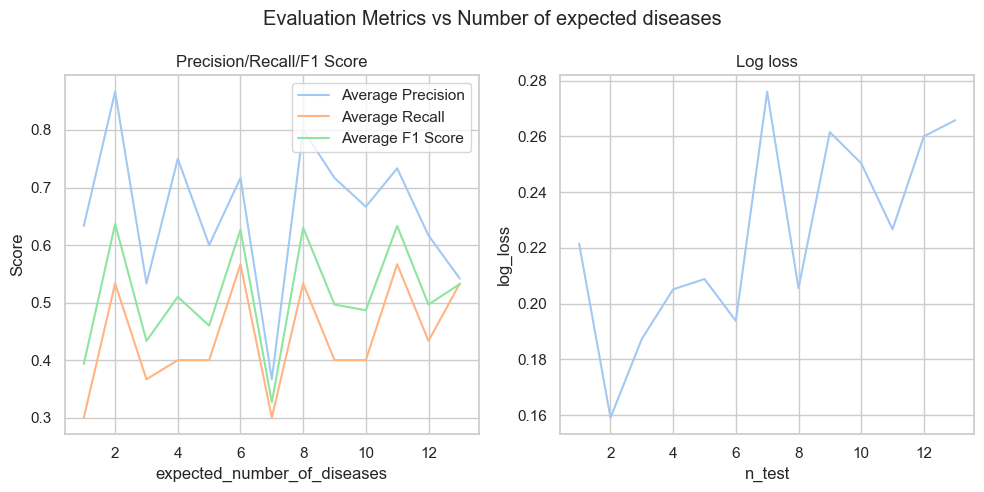

In [7]:
# Plot expected_number_of_diseases x metrics
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle("Evaluation Metrics vs Number of expected diseases")

ax[0].plot(expected_nums, mean_precision, label="Average Precision")
ax[0].plot(expected_nums, mean_recall, label="Average Recall")
ax[0].plot(expected_nums, mean_f1, label="Average F1 Score")
ax[0].set_xlabel("expected_number_of_diseases")
ax[0].set_ylabel("Score")
ax[0].set_title("Precision/Recall/F1 Score")
ax[0].legend()

ax[1].plot(expected_nums, mean_loss)
ax[1].set_xlabel("n_test")
ax[1].set_ylabel("log_loss")
ax[1].set_title("Log loss")

plt.tight_layout()


## Number of actual diagnoses - `ndiags`

In [4]:
# Parameters
n_test = 50
n_disease = 30
expected_number_of_diseases = 4

# Prevalences
prev = np.full(n_disease, expected_number_of_diseases/n_disease) 

# Connection Density
sparseness = 0.3

# Sensitivity
sensitivity = 0.4

# Connections Matrix
connections = (np.random.rand(n_test, n_disease) < sparseness)*1  
   
    
# Sensitivity Matrix
sensorig = np.full((n_test, n_disease), sensitivity) * connections

# Number of trials
n_trials = 60

In [5]:
ndiags_list = np.empty(n_trials)

precisions = np.empty(n_trials)
recalls = np.empty(n_trials)
f1s = np.empty(n_trials)
losses = np.empty(n_trials)

for i in range(n_trials):
    print(i)
    
    flag = 1
    while flag:
        actualdiags = np.where(np.random.rand(n_disease) < prev)[0]  # Generate diseases
        ndiags = len(actualdiags)
        
        # Perfect specificity assumed
        testresults = np.any(np.random.rand(n_test, ndiags) < sensorig[:, actualdiags], axis=1)  # Generate test results

        postest = np.where(testresults == 1)[0]
        negtest = np.where(testresults == 0)[0]
        m = len(postest)
        
        # m kept relatively constant with this condition
        if 12 < m < 15 and actualdiags.size > 0:
            flag = 0  # Exit loop if conditions met
#             print(f"trial: {ndiags:3.0f}, {m:3.0f} OK")
#         else:
#             print(m)
#             print(f"trial: {ndiags:3.0f}, {m:3.0f} try again")
    
    # Prepare data for Quickscore algorithm
    sens = sensorig[postest, :]                 
    sensneg = sensorig[negtest, :]              
    pfmin = 1 - sens                          
    pfminneg = np.prod(1 - sensneg, axis=0)     

    # Quickscore calculation
    posteriorg, _, _ = fun_quickscoreW2_gmpy2(prev, pfmin, pfminneg)

    actualdiseases = np.zeros_like(prev)
    actualdiseases[actualdiags] = 1

    # Metric Calculation
    metrics = compute_metrics(actualdiseases, posteriorg)
    
    precisions[i] = metrics["precision"]
    recalls[i] = metrics["recall"]
    f1s[i] = metrics["f1_score"]
    losses[i] = metrics["log_loss"]
    
    
    #Adding ndiags to the actualdiags_list
    ndiags_list[i] = ndiags

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


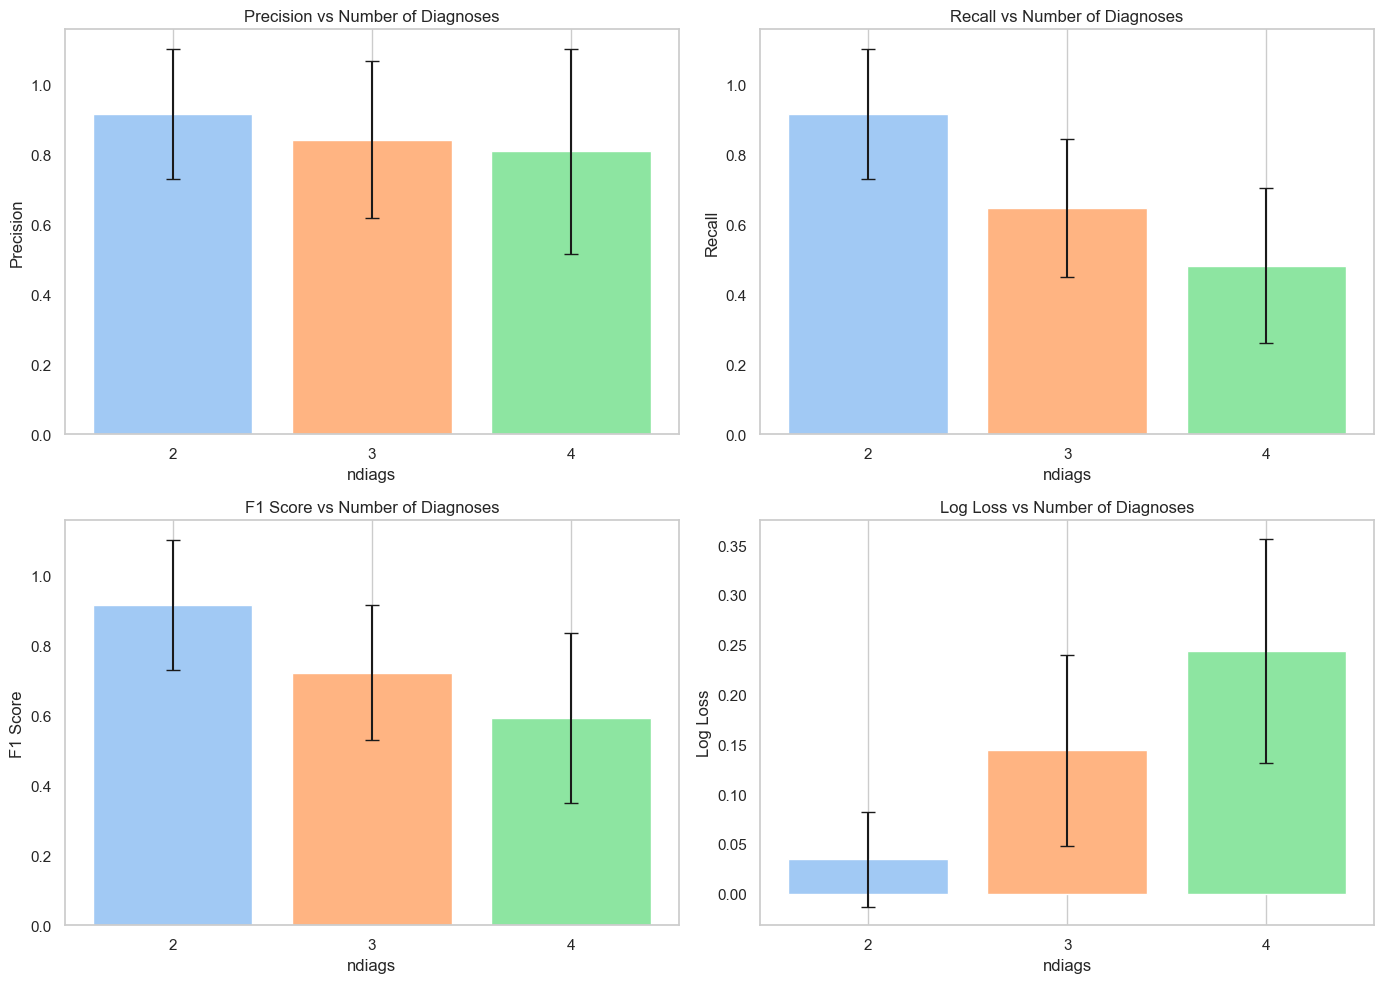

In [6]:
metrics_by_ndiags = {
    "precision": defaultdict(list),
    "recall": defaultdict(list),
    "f1_score": defaultdict(list),
    "log_loss": defaultdict(list),
}

for n, p, r, f1, l in zip(ndiags_list, precisions, recalls, f1s, losses):
    metrics_by_ndiags["precision"][n].append(p)
    metrics_by_ndiags["recall"][n].append(r)
    metrics_by_ndiags["f1_score"][n].append(f1)
    metrics_by_ndiags["log_loss"][n].append(l)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.ravel()

titles = ["Precision", "Recall", "F1 Score", "Log Loss"]
metric_keys = ["precision", "recall", "f1_score", "log_loss"]


sns.set_theme(style="whitegrid")
all_ndiags = sorted(set(ndiags_list))
colors = sns.color_palette("pastel", len(all_ndiags))
color_map = {n: colors[i] for i, n in enumerate(all_ndiags)}

for idx, key in enumerate(metric_keys):
    data_dict = metrics_by_ndiags[key]
    ndiags_vals = sorted(data_dict.keys())
    means = [np.mean(data_dict[n]) for n in ndiags_vals]
    stds = [np.std(data_dict[n]) for n in ndiags_vals]
    bar_colors = [color_map[n] for n in ndiags_vals]

    axs[idx].bar(ndiags_vals, means, yerr=stds, capsize=5,
                 color=bar_colors)
    axs[idx].set_title(f"{titles[idx]} vs Number of Diagnoses")
    axs[idx].set_xlabel("ndiags")
    axs[idx].set_ylabel(titles[idx])
    axs[idx].grid(axis='y')
    axs[idx].set_xticks(ndiags_vals)

plt.tight_layout()
plt.savefig("sp4-C.pdf", dpi=300, bbox_inches='tight')

## Number of positive findings - `m`


In [7]:
# Parameters
n_test = 40
n_disease = 30
expected_number_of_diseases = 3

# Prevalences
prev = np.full(n_disease, expected_number_of_diseases/n_disease) 

# Connection Density
sparseness = 0.3

# Sensitivity
sensitivity = 0.4

# Connections Matrix
n_connect = 6
connections = np.zeros((n_test, n_disease), dtype=int)

for i in range(n_disease):
    connected_tests = np.random.choice(n_test, size=n_connect, replace=False)
    connections[connected_tests, i] = 1 
   
    
# Sensitivity Matrix
sensorig = np.full((n_test, n_disease), sensitivity) * connections


In [8]:
n_trials=100

m_list = np.empty(n_trials)

precisions = np.empty(n_trials)
recalls = np.empty(n_trials)
f1s = np.empty(n_trials)
losses = np.empty(n_trials)

for i in range(n_trials):
    if i%5==0:
        print(i)
    flag = 1
    while flag:
        actualdiags = np.where(np.random.rand(n_disease) < prev)[0]  # Generate diseases
        ndiags = len(actualdiags)
        
        # Perfect specificity assumed
        testresults = np.any(np.random.rand(n_test, ndiags) < sensorig[:, actualdiags], axis=1)  # Generate test results

        postest = np.where(testresults == 1)[0]
        negtest = np.where(testresults == 0)[0]
        m = len(postest)
        
        # ndiags kept constant
        if m>0 and ndiags == 3:
            flag = 0  # Exit loop if conditions met
#             print(f"trial: {ndiags:3.0f}, {m:3.0f} OK")
#         else:
#             print(ndiags)
#             print(f"trial: {ndiags:3.0f}, {m:3.0f} try again")
    
    # Prepare data for Quickscore algorithm
    sens = sensorig[postest, :]                 
    sensneg = sensorig[negtest, :]              
    pfmin = 1 - sens                          
    pfminneg = np.prod(1 - sensneg, axis=0)     

    # Quickscore calculation
    posteriorg, _, _ = fun_quickscoreW2_gmpy2(prev, pfmin, pfminneg)

    actualdiseases = np.zeros_like(prev)
    actualdiseases[actualdiags] = 1

    # Metric Calculation
    metrics = compute_metrics(actualdiseases, posteriorg)
    
    precisions[i] = metrics["precision"]
    recalls[i] = metrics["recall"]
    f1s[i] = metrics["f1_score"]
    losses[i] = metrics["log_loss"]
    
    
    #Adding m to the m_list
    m_list[i] = m

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


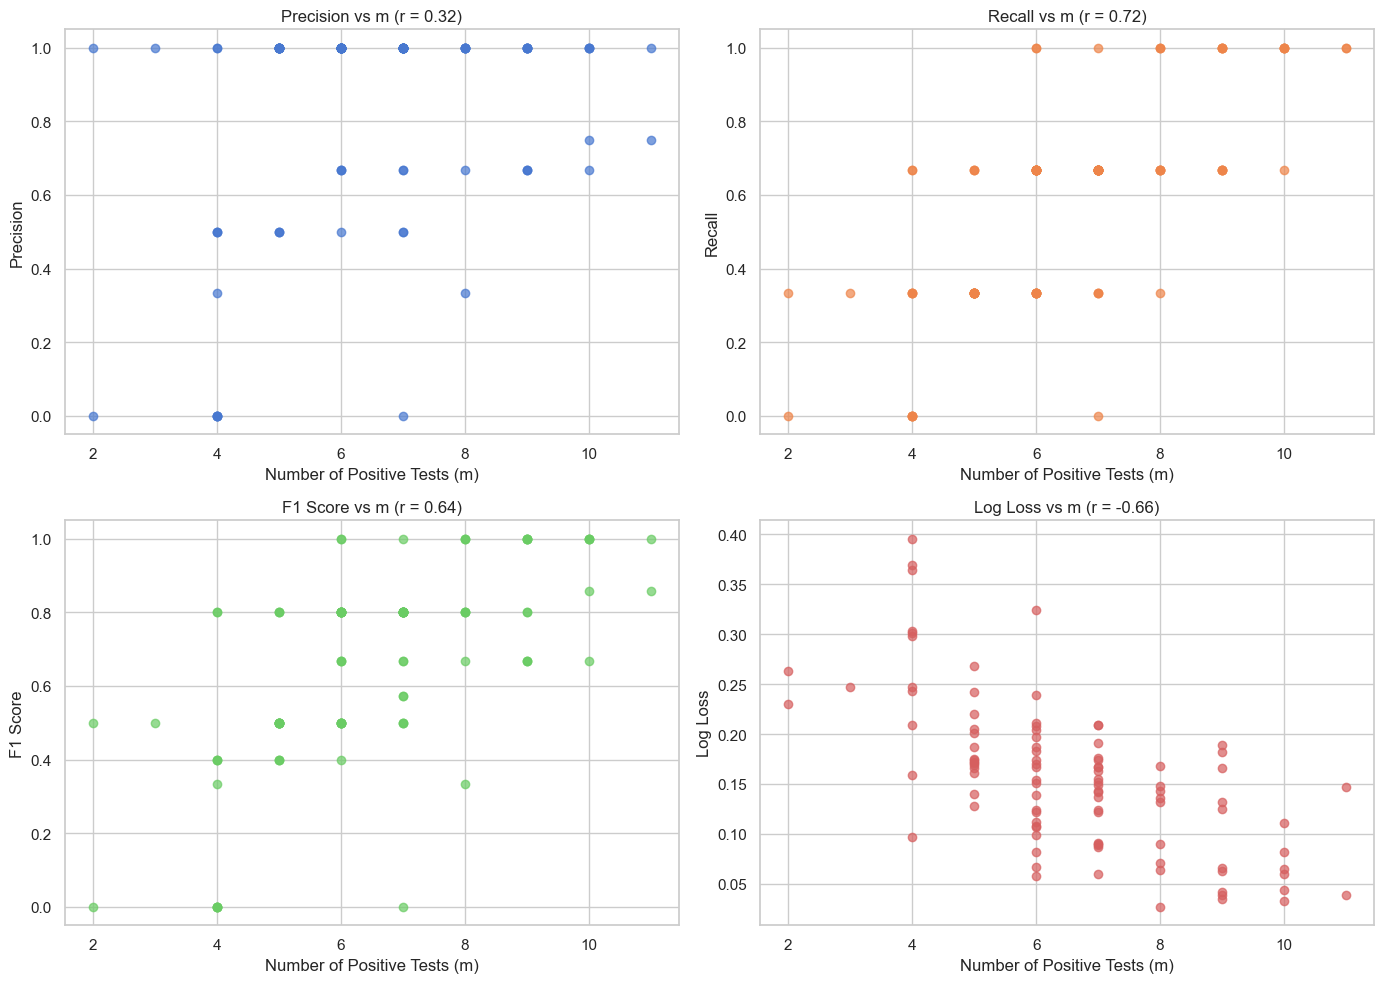

In [34]:
sns.set_theme(style="whitegrid")

metrics = {
    "Precision": precisions,
    "Recall": recalls,
    "F1 Score": f1s,
    "Log Loss": losses
}

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.ravel()

colors = sns.color_palette("muted", len(metrics))

for idx, (title, values) in enumerate(metrics.items()):
    ax = axs[idx]
    
    # Compute correlation
    corr, pval = pearsonr(m_list, values)
    
    # Scatter plot
    ax.scatter(m_list, values, color=colors[idx], alpha=0.7)
    ax.set_title(f"{title} vs m (r = {corr:.2f})")
    ax.set_xlabel("Number of Positive Tests (m)")
    ax.set_ylabel(title)
    ax.grid(True)

plt.tight_layout()

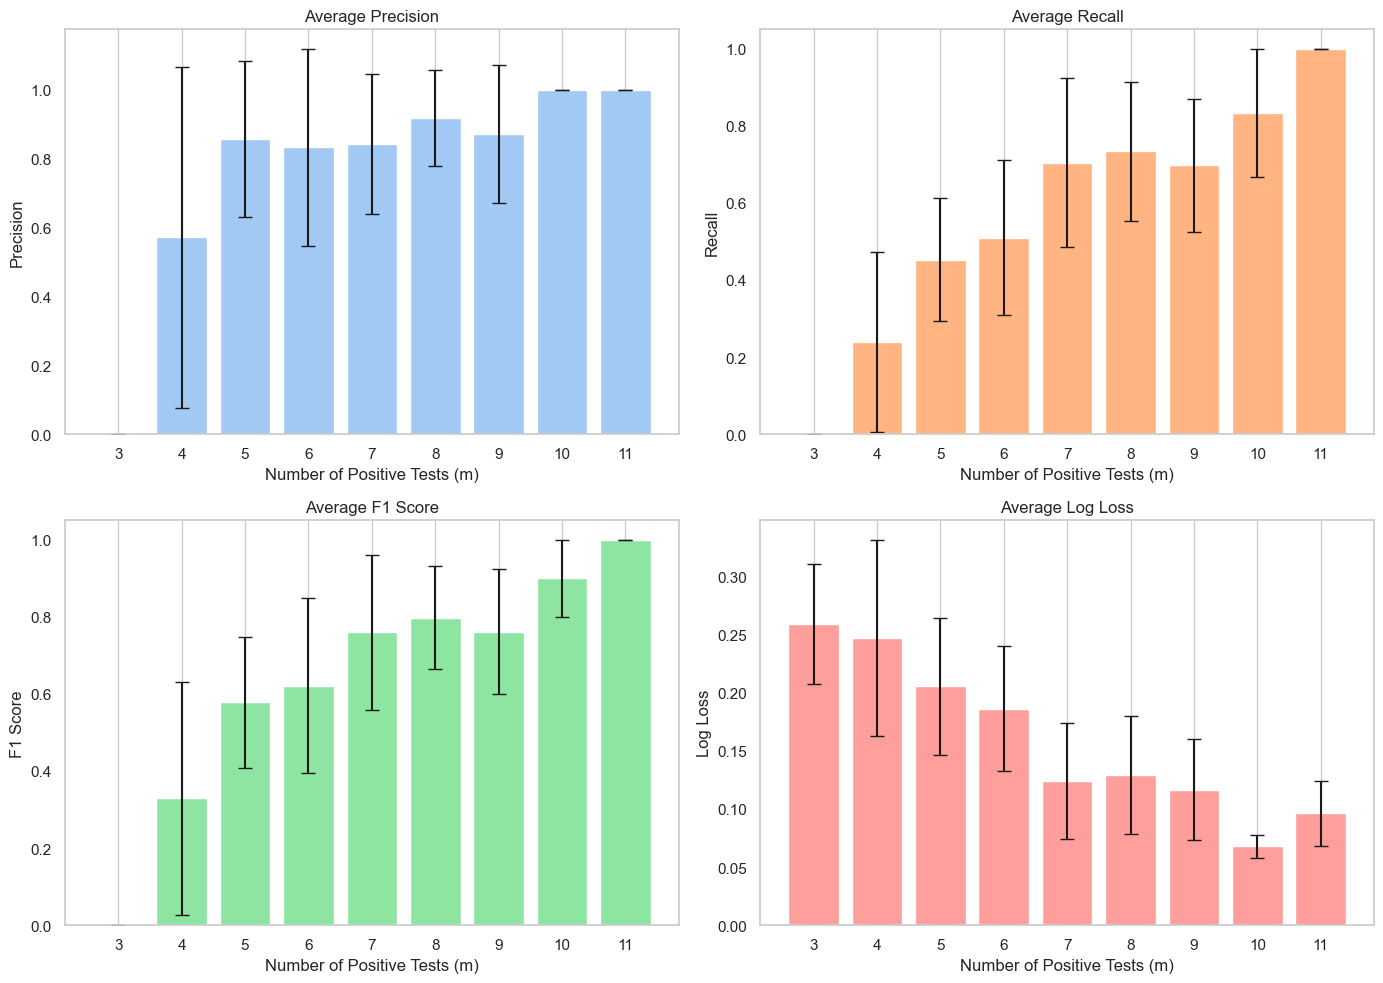

In [10]:

metrics_by_m = {
    "precision": defaultdict(list),
    "recall": defaultdict(list),
    "f1_score": defaultdict(list),
    "log_loss": defaultdict(list),
}

for m_val, p, r, f1, l in zip(m_list, precisions, recalls, f1s, losses):
    metrics_by_m["precision"][m_val].append(p)
    metrics_by_m["recall"][m_val].append(r)
    metrics_by_m["f1_score"][m_val].append(f1)
    metrics_by_m["log_loss"][m_val].append(l)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.ravel()

titles = ["Precision", "Recall", "F1 Score", "Log Loss"]
metric_keys = ["precision", "recall", "f1_score", "log_loss"]

colors = sns.color_palette("pastel", len(metric_keys))

for idx, key in enumerate(metric_keys):
    data_dict = metrics_by_m[key]
    m_vals = sorted(data_dict.keys())
    means = [np.mean(data_dict[m]) for m in m_vals]
    stds = [np.std(data_dict[m]) for m in m_vals]

    axs[idx].bar(
        m_vals, means, yerr=stds, capsize=5,
        color=colors[idx])
    axs[idx].set_title(f"Average {titles[idx]}")
    axs[idx].set_xlabel("Number of Positive Tests (m)")
    axs[idx].set_ylabel(titles[idx])
    axs[idx].grid(axis='y')
    axs[idx].set_xticks(m_vals)

plt.tight_layout()
plt.savefig("sp4-D.pdf", dpi=300, bbox_inches='tight')